The dataset contains texts from books written by spooky authors of the public domain:

1. Edgar Allan Poe (EAP)
2. HP Lovecraft (HPL)
3. Mary Wollstonecraft Shelley (MWS)

The goal is to identify the author based on the text

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spooky-author-identification/train.zip
/kaggle/input/spooky-author-identification/sample_submission.zip
/kaggle/input/spooky-author-identification/test.zip


In [2]:
!unzip '/kaggle/input/spooky-author-identification/train.zip'
!unzip '/kaggle/input/spooky-author-identification/test.zip'

Archive:  /kaggle/input/spooky-author-identification/train.zip
  inflating: train.csv               
Archive:  /kaggle/input/spooky-author-identification/test.zip
  inflating: test.csv                


In [3]:
# check if the files have been unzipped
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/test.csv
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/train.csv


In [4]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble, model_selection, metrics, naive_bayes

import time
import gc

## 1. Importing the data

In [5]:
# read train and test
train_df = pd.read_csv('/kaggle/working/train.csv')
test_df = pd.read_csv('/kaggle/working/test.csv')
print('train dataset shape', train_df.shape)
print('test dataset shape', test_df.shape)

train dataset shape (19579, 3)
test dataset shape (8392, 2)


In [6]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### 1.1 Check for class imbalances
To see if there is an equal representation of text from the authors in the dataset
There is `no high imbalance` in the classes, which could have resulted in unwanted bias

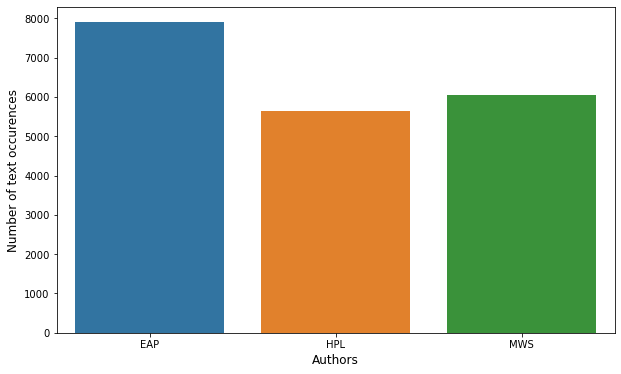

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(train_df['author'])
plt.xlabel('Authors', fontsize=12)
plt.ylabel('Number of text occurences', fontsize=12)
plt.show()

In [8]:
# Examine some of the text from each author
grouped_df = train_df.groupby('author')['text']
for author, group in grouped_df:
    print('Author name :',author,'\n', 'Text\n',group.tolist()[:5])
    print('\n')

Author name : EAP 
 Text
 ['This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.', 'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.', 'The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.', 'The surcingle hung in ribands from my body.', "I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony,

## 2. Feature engineering
Learn some features from the existing text which can be done in two parts:
> 1. __Meta features__: features extracted from existing texts such as number of of words, stop words, punctuations, characters etc
> 2. __Text based features__: features extracted directly from text such as term frequency, idf, word2vec, countvectorizer etc

### 2.1 Extract 'meta features'

Extract meta features to see how good they are at predicting the authors for which we will extract:

>Number of:
    1. words in text
    2. unique words in text
    3. punctuations
    4. stop words
    5. length of text
    6. upper case words
    7. title case words
    8. characters in text
    9. average length of words

In [9]:
import string  # for use in string.punctuation here
eng_stopwords = set(stopwords.words('english'))

# number of words in text
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique words count
train_df['num_uniq_words'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['num_uniq_words'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# punctuation count
train_df['num_punctuations'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# character count
train_df['num_chars'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x: len(str(x)))

# stop words count
train_df['num_stopwords'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# title case words count
train_df['num_words_title'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df['num_words_title'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# upper case words
train_df['num_words_upper'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# average length of words
train_df['num_words_upper'] = train_df['text'].apply(lambda x: np.mean(len([w for w in str(x).split()])))
test_df['num_words_upper'] = test_df['text'].apply(lambda x: np.mean(len([w for w in str(x).split()])))

In [10]:
# after adding new features
train_df.head(10)

,id,text,author,num_words,num_uniq_words,num_punctuations,num_chars,num_stopwords,num_words_title,num_words_upper
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,7,231,19,3,41.0
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,1,71,8,1,14.0
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,5,200,16,1,36.0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,4,206,13,4,34.0
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,4,174,11,2,27.0
5,id22965,"A youth passed in solitude, my best years spen...",MWS,83,66,6,468,43,5,83.0
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,21,21,5,128,9,1,21.0
7,id13515,The surcingle hung in ribands from my body.,EAP,8,8,1,43,4,1,8.0
8,id19322,I knew that you could not say to yourself 'ste...,EAP,88,62,11,488,45,7,88.0
9,id00912,I confess that neither the structure of langua...,MWS,23,18,3,144,11,1,23.0


### 2.3 Plot using meta features
To see how these new features can be helpful with predictions

### 2.3.1 Number of words

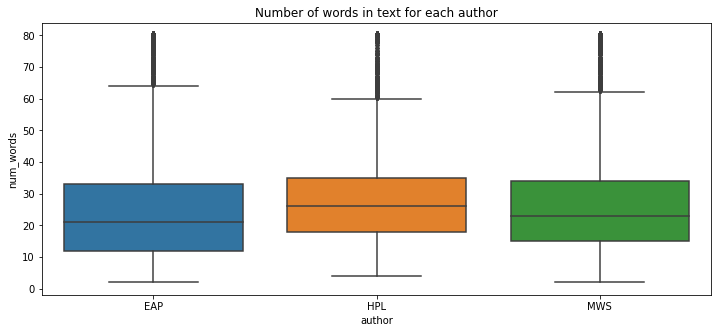

In [11]:
# truncating for better visuals
train_df.loc[train_df['num_words'] > 80, 'num_words']=80
plt.figure(figsize=(12,5))
sns.boxplot(x = 'author', y = 'num_words', data=train_df)
plt.title('Number of words in text for each author', fontsize=12)
plt.show()

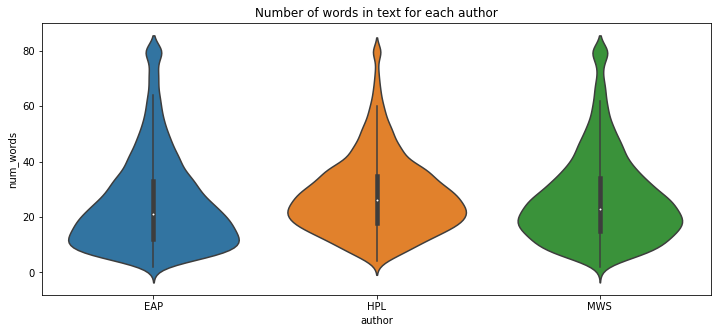

In [12]:
# using violin plot
plt.figure(figsize=(12,5))
sns.violinplot(x = 'author', y = 'num_words', data=train_df)
plt.title('Number of words in text for each author', fontsize=12)
plt.show()

### 2.3.2 Number of unique words

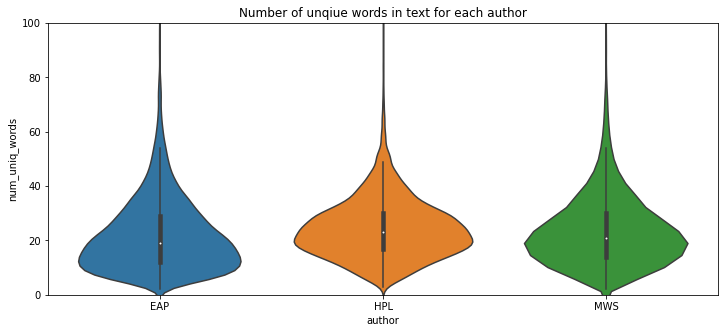

In [13]:
# using violin plot
plt.figure(figsize=(12,5))
sns.violinplot(x = 'author', y = 'num_uniq_words', data=train_df)
plt.title('Number of unqiue words in text for each author', fontsize=12)
plt.ylim(0,100)
plt.show()

### 2.3.3 Number of punctuations

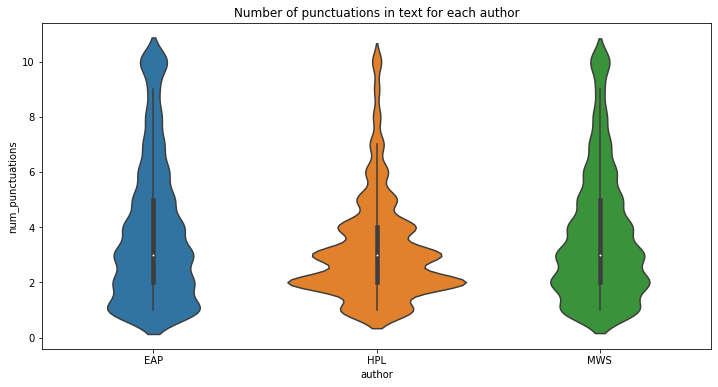

In [14]:
# using violin plot
train_df.loc[train_df['num_punctuations'] > 10, 'num_punctuations'] = 10
plt.figure(figsize=(12,6))
sns.violinplot(x = 'author', y = 'num_punctuations', data=train_df)
plt.title('Number of punctuations in text for each author', fontsize=12)
#plt.ylim(0,10)
plt.show()

### 3. Prepare the data for modeling

In [15]:
# encode label for author
author_mapping_dict ={'EAP': 0, 'HPL': 1, 'MWS': 2}
train_y = train_df['author'].map(author_mapping_dict)

# store the ids
train_id = train_df['id'].values
print('train_id shape', train_id.shape)
test_id = test_df['id'].values
print('test_id shape', test_id.shape)

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop , axis=1)

train_id shape (19579,)
test_id shape (8392,)


### 4. Train a simple XGBoost model

In [16]:
import xgboost as xgb

def runXGB(train_X, train_y, val_X, val_y = None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    
    # parameters
    params = {}
    params['max_depth'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss'
    params['num_class'] = 3
    params['eta'] = 0.1
    params['silent'] = 1   # verbosity
    params['min_child_weight'] = child
    params['colsample_bytree'] = colsample
    params['subsample'] = 0.8
    params['seed'] = seed_val
    
    num_rounds = 2000
    
    # list of paramaters values to be passed to train XGB
    params_list = list(params.items())
    
    # create the dense matrix for train
    xgtrain = xgb.DMatrix(train_X, label= train_y)
    
    if not val_y is None:
        xgval = xgb.DMatrix(val_X, label = val_y)
        watchlist = [(xgtrain, 'train'), (xgval, 'val')]
        
        # stop training the model if no improvement for 50 iterations
        model = xgb.train(params_list, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    
    else:
        xgval = xgb.DMatrix(val_X)
        model.train(params_list, xgtrain, num_rounds)
        
    pred_val_y = model.predict(xgval, ntree_limit = model.best_ntree_limit)
        
        
    # On the actual test set
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
        
    
    return (pred_val_y, pred_test_y2, model)    

**Creating a k-fold cross validation**

In [17]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2020)
cv_scores =[]

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    # test_X is the actual test set
    pred_val_y, pred_test_y, model =  runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    
    # cv scores
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    
    break # running only 1 iteration for now

print('cv scores: for logloss on simple XGBoost model', cv_scores)    

[0]	train-mlogloss:1.09389	val-mlogloss:1.09432
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04860	val-mlogloss:1.05513
[40]	train-mlogloss:1.02487	val-mlogloss:1.03569
[60]	train-mlogloss:1.01275	val-mlogloss:1.02730
[80]	train-mlogloss:1.00298	val-mlogloss:1.02119
[100]	train-mlogloss:0.99543	val-mlogloss:1.01683
[120]	train-mlogloss:0.98886	val-mlogloss:1.01260
[140]	train-mlogloss:0.98325	val-mlogloss:1.00975
[160]	train-mlogloss:0.97875	val-mlogloss:1.00718
[180]	train-mlogloss:0.97468	val-mlogloss:1.00509
[200]	train-mlogloss:0.97108	val-mlogloss:1.00425
[220]	train-mlogloss:0.96769	val-mlogloss:1.00331
[240]	train-mlogloss:0.96441	val-mlogloss:1.00201
[260]	train-mlogloss:0.96169	val-mlogloss:1.00147
[280]	train-mlogloss:0.95938	val-mlogloss:1.00030
[300]	train-mlogloss:0.95687	val-mlogloss:0.99995
[320]	train-mlogloss:0.95452	val-mlogloss:0.99915
[340]	t

__Plot the important features identified__

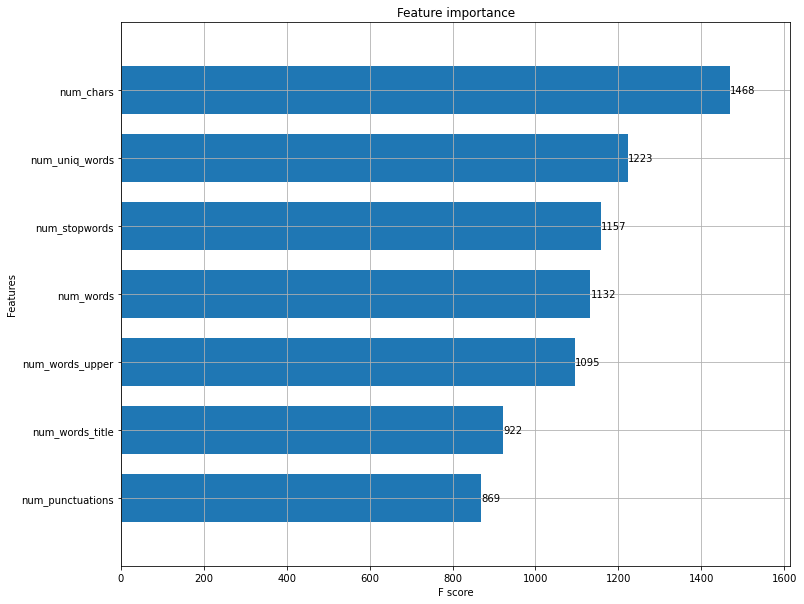

In [18]:
fig, ax = plt.subplots(figsize=(12,10))
xgb.plot_importance(model, max_num_features=50, height=0.7, ax=ax)
plt.show()

### 5. Using Text based features
We can use count vectorizer, tf-idf etc. Here I will extract tf-idf for each word

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# instantiate
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
# fit_transform on the combined train and test,as there can be pattern in test set not seen in train
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [20]:
train_tfidf

<19579x550841 sparse matrix of type '<class 'numpy.float64'>'
	with 611707 stored elements in Compressed Sparse Row format>

In [21]:
full_tfidf

<27971x550841 sparse matrix of type '<class 'numpy.float64'>'
	with 870395 stored elements in Compressed Sparse Row format>

The output from tfidf is a `sparse matrix`. So if we need to combine this with other `dense features` we have extracted there are 2 choices:
> 1. Choose the top `n features` (depending on system config) from the tfidf vectorizer, `convert` it into a dense format and `concat` with other features
> 2. Build a `model` using just the `sparse features` and then use the `predictions` as one of the features along with the `dense features`

The approach to take depends on the dataset. Here I will be using the second approach

Also `Naive Bayes` tends to perform well on this dataset. So we will build a NB model using tf-idf as it if `faster` to train

In [22]:
# since there are 3 classes, we will use a Multinomial Naive Bayes(NB) model

def runMNB(train_X, train_y, val_X, val_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    # use model.predict_proba to detect the probabilites for each of the classes
    # if using model.predict, the model just return a prediction
    pred_proba_val_y = model.predict_proba(val_X)
    pred_proba_test_y = model.predict_proba(test_X2)
    return pred_proba_val_y, pred_proba_test_y, model

### 5.1 Using 'Naive Bayes' on Word 'Tfidf vectorizer'

In [23]:
%%time
cv_scores = []
predict_val = np.zeros([train_df.shape[0], 3]) # store prediction on validation set to use in confusion matrix

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2020)

# create splits on train_X and use the tf-idf values from train_tfidf and test_tfidf

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_proba_val_y, pred_proba_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    
    
    cv_scores.append(metrics.log_loss(val_y, pred_proba_val_y))
    predict_val[val_index, :] = pred_proba_val_y
    
print('cv scores for mlogloss using NB on tf-idf at word level: ', cv_scores)
print('Mean cv scores for mlogloss using NB on tf-idf at word level: ', np.mean(cv_scores))

cv scores for mlogloss using NB on tf-idf at word level:  [0.8429642575917383, 0.8430859217155963, 0.8396143523062771, 0.8400008217155033, 0.8467269707185776]
Mean cv scores for mlogloss:  0.8424784648095386
CPU times: user 363 ms, sys: 80.2 ms, total: 443 ms
Wall time: 442 ms


we are getting mlogloss of 0.84 using tf-idf vectorizer, which is better than using just the meta features

__Plot confusion matrix__
- Using sklearn confusion_matrix only provides a one Vz rest tranformation so it is not useful here
- Another option is to use a custom script as mentioned [here](https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python)
- I have used mlxtend library for cleaner code

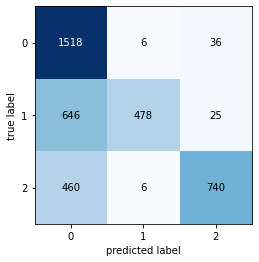

In [24]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(val_y, np.argmax(pred_proba_val_y, axis=1), binary=False)
fig, ax = plot_confusion_matrix(cm)
plt.show()

### 5.2 Using SVD (Singular Value Decomposition) on Tf-idf
- this will help to compress the information in the high dimensional sparse tf-idf vectors
- we will compress tf-idf vectors using SVD and use them as features in the ML models
- from the helper notes:
      In particular, truncated SVD works on term count/tf-idf matrices as
      returned by the vectorizers in sklearn.feature_extraction.text. In that
      context, it is known as latent semantic analysis (LSA).

      This estimator supports two algorithms: a fast randomized SVD solver, and
      a "naive" algorithm that uses ARPACK as an eigensolver on (X * X.T) or
      (X.T * X), whichever is more efficient.

In [25]:
from sklearn.decomposition import TruncatedSVD

n_comp= 20

svd_obj = TruncatedSVD(n_components=n_comp, algorithm ='arpack')
svd_obj.fit(full_tfidf)

train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

# renaming columns
train_svd.columns = ['svd_tfidf_word_'+ str(i) for i in range(n_comp)]
test_svd.columns = ['svd_tfidf_word_'+ str(i) for i in range(n_comp)]

# concat the information original train_df
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd
gc.collect()

3304

In [26]:
# glimse after the merge with SVD features
display(train_df.sample(2))
display(test_df.sample(2))

,id,text,author,num_words,num_uniq_words,num_punctuations,num_chars,num_stopwords,num_words_title,num_words_upper,...,svd_tfidf_word_10,svd_tfidf_word_11,svd_tfidf_word_12,svd_tfidf_word_13,svd_tfidf_word_14,svd_tfidf_word_15,svd_tfidf_word_16,svd_tfidf_word_17,svd_tfidf_word_18,svd_tfidf_word_19
15499,id20006,"Was, indeed, Fate preserving my reason only to...",HPL,24,23,3,136,11,2,24.0,...,0.005058,-0.000198,0.015198,-0.008451,-0.000015,-0.027450,-0.006762,-0.000561,-0.002588,0.005216
7248,id25696,"My voice, although harsh, had nothing terrible...",MWS,44,36,7,236,22,6,44.0,...,-0.002398,-0.000448,-0.027322,0.002279,0.041267,0.024998,-0.002766,-0.011688,0.036335,-0.040310


,id,text,num_words,num_uniq_words,num_punctuations,num_chars,num_stopwords,num_words_title,num_words_upper,svd_tfidf_word_0,...,svd_tfidf_word_10,svd_tfidf_word_11,svd_tfidf_word_12,svd_tfidf_word_13,svd_tfidf_word_14,svd_tfidf_word_15,svd_tfidf_word_16,svd_tfidf_word_17,svd_tfidf_word_18,svd_tfidf_word_19
4966,id03185,"Hereafter, perhaps, some intellect may be foun...",51,41,8,311,25,2,51.0,0.022431,...,0.002964,-0.001956,-0.005307,0.003934,-0.009511,-0.004354,-0.001529,0.001354,-0.006429,0.002046
7797,id16759,The infant had been placed with these good peo...,16,16,2,86,9,1,16.0,0.025917,...,-0.003649,-0.003453,-0.018471,0.004053,0.004729,0.020537,-0.007719,-0.002469,-0.002703,0.007282


### 5.3 Using Naive Bayes on Count Vectorizer

In [27]:
%%time
count_vec = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,3))
count_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())

train_count_vec = count_vec.transform(train_df['text'].values.tolist())
test_count_vec = count_vec.transform(test_df['text'].values.tolist())

CPU times: user 6.74 s, sys: 140 ms, total: 6.88 s
Wall time: 6.89 s


In [28]:
train_count_vec.shape

(19579, 550841)

In [29]:
test_count_vec.shape

(8392, 550841)

*Use MultinomialNB model with count vectorized features*
- and then use the predictions as features

In [30]:
cv_scores =[]
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2020)

for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_count_vec[dev_index], train_count_vec[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_proba_val_y, pred_proba_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_count_vec)
    # append the scores in test from each fold
    pred_full_test += pred_proba_test_y
    # store the data corresponding to the validation indexes
    pred_train[val_index,:] = pred_proba_val_y    
    
    cv_scores.append(metrics.log_loss(val_y, pred_proba_val_y))
    
print('Mean logloss score: using NB on Count Vectorize at word level ', np.mean(cv_scores))

Mean logloss score: using NB on Count Vectorize at word level  0.45038813416923523


Using count vectorizer in place of tf-idf results in better logloss score

In [31]:
# columns reprsent the probability of belonging to the 3 classes
pred_train.shape

(19579, 3)

* __Add the predictions from (NB on CountVectoriser) as new features into our data__

In [32]:
# check if the number of rows is the same
assert pred_train.shape[0] == train_df.shape[0]

train_df['nb_cvec_eap'] = pred_train[:, 0]
train_df['nb_cvec_hpl'] = pred_train[:, 1]
train_df['nb_cvec_mws'] = pred_train[:, 2]

assert pred_full_test.shape[0] == test_df.shape[0]

test_df['nb_cvec_eap'] = pred_full_test[:, 0]
test_df['nb_cvec_hpl'] = pred_full_test[:, 1]
test_df['nb_cvec_mws'] = pred_full_test[:, 2]

### 5.3.1 Confusion matrix for NB on CountVectorizer

The confusion matrix looks to be better than using with tf-idf

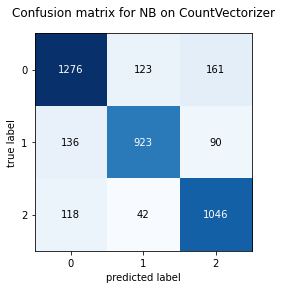

In [33]:
# using mlxtend
cm = confusion_matrix(val_y, np.argmax(pred_proba_val_y, axis=1), binary=False)
#plt.figure(figsize=(10,10))
plot_confusion_matrix(cm)
plt.title('Confusion matrix for NB on CountVectorizer')
plt.show()

### 5.4 Using Naive Bayes on 'character' Count vectorizer
Instead of counting only the special characters, we will use count vectorizer at character level

In [34]:
%%time

count_vec_char = CountVectorizer(ngram_range=(1,7), analyzer='char')
count_vec_char.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())

train_cvec_char = count_vec_char.transform(train_df['text'])
test_cvec_char = count_vec_char.transform(test_df['text'])

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2020)

for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_cvec_char[dev_index], train_cvec_char[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_proba_val_y, pred_proba_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_cvec_char)
    # append the scores in test from each fold
    pred_full_test += pred_proba_test_y
    # store the data corresponding to the validation indexes
    pred_train[val_index,:] = pred_proba_val_y    
    
    cv_scores.append(metrics.log_loss(val_y, pred_proba_val_y))

print('Mean logloss score using Naive Bayes on character Count vectorizer', np.mean(cv_scores))

Mean logloss score using Naive Bayes on character Count vectorizer 3.748797908512786
CPU times: user 1min 25s, sys: 2.12 s, total: 1min 27s
Wall time: 1min 27s


The cv score is very high using `character level` representation. But this could add some different information that `word` level features and this will be used in the final model

* __Add the predictions from (NB on CountVectoriser at character level) as new features into our data__

In [35]:
# check if the number of rows is the same
assert pred_train.shape[0] == train_df.shape[0]

train_df['nb_cvec_char_eap'] = pred_train[:, 0]
train_df['nb_cvec_char_hpl'] = pred_train[:, 1]
train_df['nb_cvec_char_mws'] = pred_train[:, 2]

assert pred_full_test.shape[0] == test_df.shape[0]

test_df['nb_cvec_char_eap'] = pred_full_test[:, 0]
test_df['nb_cvec_char_hpl'] = pred_full_test[:, 1]
test_df['nb_cvec_char_mws'] = pred_full_test[:, 2]

### 6. Use Naive Bayes on 'character' tf-idf vectorizer

In [36]:
%%time
# tf-idf tranformation at character level

tfidf_char_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
# use the fit_transform method if need to apply transformation on the data at a later stage. Since we are using SVD at a later
# stage it is better to apply the fit_transform method
full_tfidf = tfidf_char_vec.fit_transform(train_df['text'].values.tolist() +  test_df['text'].values.tolist())

train_tfidf_char_vec = tfidf_char_vec.transform(train_df['text'].values.tolist())
test_tfidf_char_vec = tfidf_char_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])

# use naive bayes
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2020)

for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_tfidf_char_vec[dev_index], train_tfidf_char_vec[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_proba_val_y, pred_proba_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf_char_vec)
    # append the scores in test from each fold
    pred_full_test += pred_proba_test_y
    # store the data corresponding to the validation indexes
    pred_train[val_index,:] = pred_proba_val_y    
    
    cv_scores.append(metrics.log_loss(val_y, pred_proba_val_y))


print('Mean logloss score: using NB on tf-idf tranformation at character level', np.mean(cv_scores))

Mean logloss score: using NB on tf-idf tranformation at character level 0.7914051360583582
CPU times: user 49.8 s, sys: 637 ms, total: 50.4 s
Wall time: 50.4 s


In [37]:
# check if the number of rows is the same
assert pred_train.shape[0] == train_df.shape[0]

train_df['nb_tfidf_char_eap'] = pred_train[:, 0]
train_df['nb_tfidf_char_hpl'] = pred_train[:, 1]
train_df['nb_tfidf_char_mws'] = pred_train[:, 2]

assert pred_full_test.shape[0] == test_df.shape[0]

print('test_df shape', test_df.shape)

test_df['nb_tfidf_char_eap'] = pred_full_test[:, 0]
test_df['nb_tfidf_char_hpl'] = pred_full_test[:, 1]
test_df['nb_tfidf_char_mws'] = pred_full_test[:, 2]

test_df shape (8392, 35)


### 6.1 Using SVD on 'character' tf-idf
Since we saw some improvements in using 'char' implementation of Count Vectorizer, I think we should also explore using the same with SVD on tf-idf vectorizer and use Naive Bayes to make prediction using features

In [38]:
%%time
# extract 20 features from the high dimensional tf-idf vector space
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)

train_svd_char = svd_obj.transform(train_tfidf_char_vec)
test_svd_char  = svd_obj.transform(test_tfidf_char_vec)

# create pandas dataframe, so that we can add them as features and renaming the columns for more clarity
train_svd_char = pd.DataFrame(train_svd_char, columns = ['svd_tfidf_char_'+ str(i) for i in range(n_comp)])
test_svd_char = pd.DataFrame(test_svd_char, columns = ['svd_tfidf_char_'+ str(i) for i in range(n_comp)])

# concat them with the original train and test to add these new features there
train_df = pd.concat([train_df, train_svd_char], axis=1)
test_df  = pd.concat([test_df, test_svd_char], axis=1)

del svd_obj, train_svd_char, test_svd_char, full_tfidf, train_tfidf_char_vec, test_tfidf_char_vec
gc.collect()

(8392, 58)
(19579, 59)
(8392, 20)
CPU times: user 22 s, sys: 447 ms, total: 22.5 s
Wall time: 11.8 s


In [39]:
train_df.columns

Index(['id', 'text', 'author', 'num_words', 'num_uniq_words',
       'num_punctuations', 'num_chars', 'num_stopwords', 'num_words_title',
       'num_words_upper', 'svd_tfidf_word_0', 'svd_tfidf_word_1',
       'svd_tfidf_word_2', 'svd_tfidf_word_3', 'svd_tfidf_word_4',
       'svd_tfidf_word_5', 'svd_tfidf_word_6', 'svd_tfidf_word_7',
       'svd_tfidf_word_8', 'svd_tfidf_word_9', 'svd_tfidf_word_10',
       'svd_tfidf_word_11', 'svd_tfidf_word_12', 'svd_tfidf_word_13',
       'svd_tfidf_word_14', 'svd_tfidf_word_15', 'svd_tfidf_word_16',
       'svd_tfidf_word_17', 'svd_tfidf_word_18', 'svd_tfidf_word_19',
       'nb_cvec_eap', 'nb_cvec_hpl', 'nb_cvec_mws', 'nb_cvec_char_eap',
       'nb_cvec_char_hpl', 'nb_cvec_char_mws', 'nb_tfidf_char_eap',
       'nb_tfidf_char_hpl', 'nb_tfidf_char_mws', 'svd_tfidf_char_0',
       'svd_tfidf_char_1', 'svd_tfidf_char_2', 'svd_tfidf_char_3',
       'svd_tfidf_char_4', 'svd_tfidf_char_5', 'svd_tfidf_char_6',
       'svd_tfidf_char_7', 'svd_tfidf_cha

### 7. XGBoost model with all created features
With all the new features we can re-run a XGBoost model and evaluate results

In [40]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

cv_scores = []
pred_full_test = 0
pred_val = np.zeros([train_df.shape[0], 3])

# run K-Fold cross validation
kf = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 2020)

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
        
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    
    pred_full_test = pred_full_test + pred_test_y
    pred_val[val_index, :] = pred_val_y
    
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    #break # remove to run across all 5 folds

# create a dataframe for the predictions
out_df = pd.DataFrame(pred_full_test, columns = ['EAP', 'HPL', 'MWS'])
# insert the id column at column 0
out_df.insert(0, 'id', test_id)
out_df.to_csv('submission.csv', index=False)

print('cv scores for log_loss using tf-idf at char level using xgboost is:', cv_scores)

[0]	train-mlogloss:1.00597	val-mlogloss:1.00757
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.40958	val-mlogloss:0.42286
[40]	train-mlogloss:0.33813	val-mlogloss:0.36134
[60]	train-mlogloss:0.31278	val-mlogloss:0.34541
[80]	train-mlogloss:0.29541	val-mlogloss:0.33613
[100]	train-mlogloss:0.28219	val-mlogloss:0.33086
[120]	train-mlogloss:0.27148	val-mlogloss:0.32718
[140]	train-mlogloss:0.26264	val-mlogloss:0.32520
[160]	train-mlogloss:0.25428	val-mlogloss:0.32319
[180]	train-mlogloss:0.24665	val-mlogloss:0.32227
[200]	train-mlogloss:0.23951	val-mlogloss:0.32124
[220]	train-mlogloss:0.23268	val-mlogloss:0.32038
[240]	train-mlogloss:0.22645	val-mlogloss:0.32002
[260]	train-mlogloss:0.22064	val-mlogloss:0.31912
[280]	train-mlogloss:0.21477	val-mlogloss:0.31904
[300]	train-mlogloss:0.20898	val-mlogloss:0.31858
[320]	train-mlogloss:0.20374	val-mlogloss:0.31863
[340]	t

The resultant score is better than what we have seen so far. This means the model has learnt quite well to distinguish between the author based on features derived
Lets look at some of the important features again

Most of the important features are those derived from naive bayes

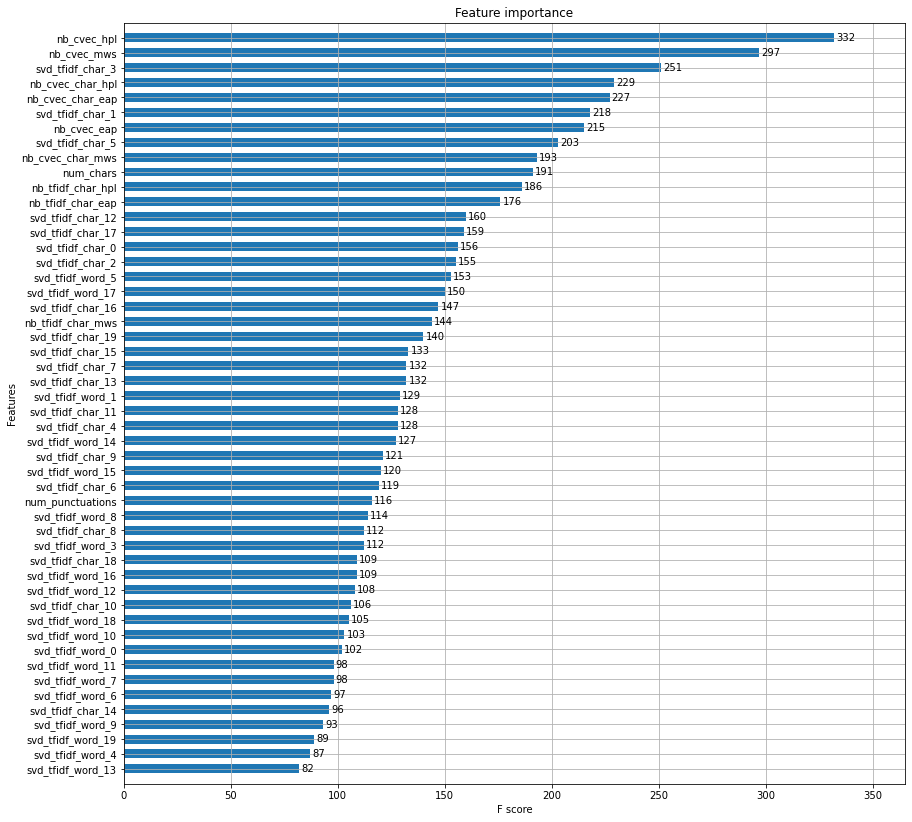

In [48]:
fig, ax = plt.subplots(figsize=(14,14))
xgb.plot_importance(model, max_num_features=50, height=0.6, ax=ax)
plt.show()

### 7.1 Plot confusion matrix for the final model

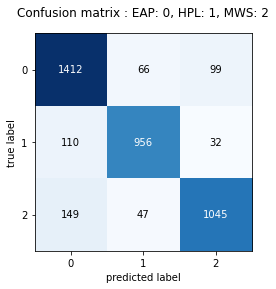

In [55]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
plot_confusion_matrix(cm)
plt.title('Confusion matrix authors: EAP: 0, HPL: 1, MWS: 2')
plt.show()

From the confusion matrix, we there are still misclassifications for 'EAP', class 0 and 'MWS, class 2,
Next step would be to explore `word embeddings`, or other `meta features` or even `sentiment analysis`